In [5]:
from time import process_time
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
from matplotlib import pyplot as plt
import math
from sklearn.linear_model import LinearRegression
from statistics import mean

RED = (255,0,0)
GREEN = (0,255,0)
BLUE = (0,0,255)
EDGESEGMENT = 25 #looks at the edge of a possibly corner +- so many points
EDGECORNER = 5
DEGREE_DEVIATION = 20/360*2*np.pi #degrees for checking direction of plain edges vs unitVector
DEGREE_WRONG = 50/360*2*np.pi
EDGE_DEV = 10 #pixelwidth thats not counted as "Noppel"

#for separation inside- or outside
def distance_point_to_line(line_a,line_b,point): # negative: out, positive: inside
    p1,p2,p3 = np.asarray(line_a), np.asarray(line_b), np.asarray(point)
    d=(np.cross(p2-p1,p3-p1)/np.linalg.norm(p2-p1))
    return d

# finding point close to detected corner, which is not exactly on the border
def points_close(p1,p2):
    if (abs(p1[0]-p2[0]) > 10 or abs(p1[1]-p2[1]) > 10):
        return False
    return True


def vector_face_same_direction(unitV,vector):
    match = np.dot(unitV,vector/np.linalg.norm(vector)) #max:1, min:-1 (return)
    minMatch = np.cos(DEGREE_DEVIATION)
    maxErr = np.cos(DEGREE_WRONG)
    if match > minMatch:
        return 1
    if match < maxErr:
        return -1
    else:
        return 0

#if p1 is closer to picCorner on left side, -1, on right +1, else 0
#additionally discarding points "behind" other points from being possible corners
def left_or_right(p1,p2,cornerNo):
    if cornerNo == 0:
        if p1[0] < p2[0] and p1[1] < p2[1]:
            return 2 #delete p2
        elif p1[0] > p2[0] and p1[1] > p2[1]:
            return 0 # delete p1
        elif p1[0] < p2[0] or p1[1] > p2[1]:
            return -1 #left
        else:
            return 1 #right
        
    if cornerNo == 1:
        if p1[0] > p2[0] and p1[1] < p2[1]:
            return 2 #delete p2
        elif p1[0] < p2[0] and p1[1] > p2[1]:
            return 0 # delete p1
        elif p1[0] < p2[0] or p1[1] < p2[1]:
            return -1 #left
        else:
            return 1 #right
        
    if cornerNo == 2:
        if p1[0] > p2[0] and p1[1] > p2[1]:
            return 2 #delete p2
        elif p1[0] < p2[0] and p1[1] < p2[1]:
            return 0 # delete p1
        elif p1[0] < p2[0] or p1[1] > p2[1]:
            return -1 #left
        else:
            return 1 #right
        
    if cornerNo == 3:
        if p1[0] < p2[0] and p1[1] > p2[1]:
            return 2 #delete p2
        elif p1[0] > p2[0] and p1[1] < p2[1]:
            return 0 # delete p1
        elif p1[0] < p2[0] or p1[1] < p2[1]:
            return -1 #left
        else:
            return 1 #right


def correctly_directed_corner(point,p_bef,p_aft,cornerNo):
    v_bef = np.subtract(p_bef,point)
    v_bef = v_bef/np.linalg.norm(v_bef)
    v_aft = np.subtract(p_aft,point)
    v_aft = v_aft/np.linalg.norm(v_aft)
    if cornerNo == 0 or cornerNo == 2:
        if (abs(v_bef[0]) < 0.7 and abs(v_aft[1]) < 0.7):
            return True
        else:
            return False
    if cornerNo == 1 or cornerNo == 3:
        if (abs(v_bef[1]) < 0.7 and abs(v_aft[0]) < 0.7):
            return True
        else:
            return False
        
class Point:
    def __init__(self, index, position):
        self.index = index
        self.position = position

class Picture:
    def __init__(self, id):
        self.id = id
        
    def set_path(self, path):
        path = path
        picNo = picture.id
        if picNo < 10:
            path += "000"
        elif picNo < 100:
            path += "00"
        elif picNo < 1000:
            path += "0"
        else:
            path = path
        path += str(picNo) + ".jpg"
        self.path = path
        
    def set_image(self):
        path = picture.path
        img_inp = cv2.imread(path)
        h,w = img_inp.shape[0:2]
        img = np.zeros((h+8,w+8, 3), dtype=np.uint8)
        img = cv2.bitwise_not(img)
        img[4:h+4,4:w+4] = img_inp
        self.image = img

    # converting image to threshhold for edge-detection
    def set_threshold(self):
        gray   = cv2.cvtColor(self.image, cv2.COLOR_BGR2GRAY)
        h,w = gray.shape[0:2]
        base_size = h+2, w+2
        base = np.zeros(base_size, dtype=np.uint8)
        thresh = cv2.threshold(gray, 240, 255, cv2.THRESH_BINARY)[1]
        cv2.floodFill(thresh, base, (0,0), 255)
        thresh = base[1:,1:]
 #       plt.imshow(thresh)
        plt.show()
        self.threshold = thresh

    def set_pic_corners(self):
        imX, imY, imZ= self.image.shape
        self.picCorners = [(0,0),(imY,0),(imY,imX),(0,imX)]

    def set_edge(self):
        thresholdPicture = self.threshold
        contours, hierarchy = cv2.findContours(thresholdPicture,cv2.RETR_CCOMP, cv2.CHAIN_APPROX_NONE) 
        img = picture.image.copy()
    
        edge = []
        contours.pop(0)
        cont_len = [len(i) for i in contours]
        max = np.argmax(cont_len) #considered the main edge
        for p in contours[max]:
            point = list(p[0])
            point = (point[0],point[1])
            edge.append(point)
        for i in range(0,len(edge)):
            if not points_close(edge[i],edge[(i+1)%len(edge)]):
                print("Edge not coherent",i,edge[i],edge[(i+1)%len(edge)])
        # e_img = picture.image.copy()
        # i = 0
        # for e in edge:
        #     cv2.circle(e_img, e,1,(0,i,0),-1) 
        #     i+=0.3
        self.edge = edge

    def set_points(self):
        points_calc = cv2.goodFeaturesToTrack(self.threshold,70,0.1,10)
        points_calc = np.int0(points_calc)
        points_pre = []
        for point in points_calc:
            points_pre.append(list(point.ravel()))
        edge = list(enumerate(self.edge.copy()))
        points = []
        # for corner in points_pre: #takes about 0.2s each!
        #      def distToP(x):
        #          return np.linalg.norm(np.subtract(x[1],corner))
        #      edge.sort(key=distToP)   
        #      index, position = edge[0]
        # down to 0.04s
        for point in points_pre:
            for edgePoint in edge:
                if (abs(edgePoint[1][0]-point[0]) <= 1 and abs(edgePoint[1][1]-point[1]) <=1):
                    points.append(Point(edgePoint[0],edgePoint[1]))
                    break          
        self.points = points

            
    
    def set_subsets_by_quadrant(self):
        subsets = [[],[],[],[]]
        picMid = (self.picCorners[2][0]/2, self.picCorners[2][1]/2)
        for point in self.points:
            if (point.position[0] < picMid[0] and point.position[1] < picMid[1]):
                subsets[0].append(point)
            elif (point.position[0] > picMid[0] and point.position[1] < picMid[1]):
                subsets[1].append(point)
            elif (point.position[0] > picMid[0] and point.position[1] > picMid[1]):
                subsets[2].append(point)
            elif (point.position[0] < picMid[0] and point.position[1] > picMid[1]):
                subsets[3].append(point)
        self.subsets = subsets
        
    def set_subset_points(self):
        def sort(e):
            return e[len(e)-1]
        subsets = self.subsets
        for cornerNo in range(0,4):
            subCompare = subsets[cornerNo].copy()
            
            for point in subCompare:
                for otherPoint in subCompare:
                    useless = left_or_right(point.position,otherPoint.position,cornerNo)
                    if useless == 0:
                        if point in subsets[cornerNo]:
                            subsets[cornerNo].pop(subsets[cornerNo].index(point))
        self.subsets = subsets
        
    def save_subsets(self):
        
        image = self.image.copy()   
        color = [(255,255,0),(0,0,255),(0,255,0),(255,0,0)]
        for cornerNo in range(0,4):
            for point in self.subsets[cornerNo]:
                cv2.circle(image,point.position,8-cornerNo,color[cornerNo],-1)
      #  plt.imshow(image)
        cv2.imwrite("img/tempCornImg/"+str(self.id)+".jpg", image)
       # plt.show()
                    
        
    def plot_points(self, points):
        image = self.image.copy()
        for point in points:
            cv2.circle(image,point.position,4,(0,0,255),-1)
        plt.imshow(image)
        plt.show()
        
    def plot_subset_points(self):
        image = self.image.copy()   
        color = [(255,255,0),(0,0,255),(0,255,0),(255,0,0)]
        for cornerNo in range(0,4):
            for point in self.subsets[cornerNo]:
                cv2.circle(image,point.position,8-cornerNo,color[cornerNo],-1)
        plt.imshow(image)
        plt.show()
    
    def get_point_edge(self, point):
        edge_before, edge_after = [],[]
        for i in range(0,EDGESEGMENT):
            edge_before.append(self.edge[point.index-(1+i)])
            edge_after.append(self.edge[point.index+(1+i)-(len(self.edge))])
        return edge_before, edge_after
        
    def plot_edge(self, edge, color):
        image = self.image.copy() 
        for point in edge:
            cv2.circle(image,point,1,color,-1)
        plt.imshow(image)
        plt.show()
    
    def reduce_subsets_by_edge_direction(self):
        subsets = [[],[],[],[]]
        for subset in self.subsets:
            cornerNo = self.subsets.index(subset)
            for point in subset:
                point_bef = self.edge[point.index-EDGESEGMENT]
                point_aft = self.edge[(point.index+EDGESEGMENT)%len(self.edge)]
                if correctly_directed_corner(point.position, point_bef, point_aft,cornerNo):
                    subsets[cornerNo].append(point)
        self.subsets = subsets
    
    def get_unit_vectors_for_subsets(self):
        subsets = self.subsets.copy()
        for subset in subsets:
            for point in subset:
                edge_bef, edge_aft = self.get_point_edge(point)
                vectors = [(0,0),(0,0)]
                vectors[0] += (np.subtract(edge_bef[EDGESEGMENT-1],point.position))
                vectors[1] += (np.subtract(edge_aft[EDGESEGMENT-1],point.position))
                    
                vectors[0] =vectors[0]/np.linalg.norm(vectors[0])
                vectors[1] =vectors[1]/np.linalg.norm(vectors[1])
                point.vectors = vectors
        self.subsets = subsets

    
    def reduce_subsets_by_scalproduct(self):
        new_subsets = [[],[],[],[]]
        sums = [[],[],[],[]]
        def scal_prod_sum_of_edges(point, edge1, edge2):
            sum = 0
            for i in range(0,EDGESEGMENT):
                v1 = (np.subtract(edge1[i],point))
                v1 = v1/np.linalg.norm(v1)
                v2 = (np.subtract(edge2[i],point))
                v2 = v2/np.linalg.norm(v2)
                sum -= (np.cross(v1,v2))
            return sum/EDGESEGMENT
        
        for subset in self.subsets:
            for point in subset:
                edge_bef, edge_aft = self.get_point_edge(point)
                sums[self.subsets.index(subset)].append(scal_prod_sum_of_edges(point.position,edge_bef,edge_aft))
        for sum in sums:
            for entry in sum:
                if max(sum)-entry < 0.3:
                    new_subsets[sums.index(sum)].append(self.subsets[sums.index(sum)][sum.index(entry)])
        self.subsets = new_subsets
        
    def save_corners(self):
        image = self.image.copy()   
        for point in self.corners:
            cv2.circle(image,point.position,10,(0,0,255),-1)
        cv2.imwrite("img/tempCornImg/"+str(self.id)+".jpg", image)
    
    def save_subsets(self):
        image = self.image.copy()   
        for subset in self.subsets:
            for point in subset:
                cv2.circle(image,point.position,10,(0,0,255),-1)
        cv2.imwrite("img/tempSubImg/"+str(self.id)+".jpg", image)
    
    def find_pieces_without_hit_corner(self):
        i = 0
        for subset in self.subsets:
            if len(subset)>1:
                i+=1
        if i == 4:
            print("no corner for sure!")
            picture.plot_subset_points()
    
    def reduce_subset_by_longterm_edge_direction(self):
        length = int(len(self.edge)/4)
        for subset in self.subsets:
            if len(subset) > 1:
                new_subset = []
                counters = []
                for point in subset:
                    counter = 0
                    for distance in range(EDGESEGMENT,length):
                        v_bef = np.subtract(self.edge[point.index-distance],point.position)
                        v_aft = np.subtract(self.edge[point.index+distance-len(self.edge)],point.position)
                        counter += vector_face_same_direction(point.vectors[0],v_bef)
                        counter += vector_face_same_direction(point.vectors[1],v_aft)
                    counters.append(counter)
                for i in range(0,len(counters)):
                    if max(counters)-counters[i] < 40:
                        new_subset.append(subset[i])
                self.subsets[self.subsets.index(subset)] = new_subset
    
    def plot_unitvectors(self, point):
        image = self.image.copy()
        for x in range(1,50):
            linePoint = (np.add(point.position,x*point.vectors[0]))
            linePoint = tuple(map(lambda x: int(x), linePoint))
            cv2.circle(image,linePoint,1, RED,-1)
            linePoint = (np.add(point.position,x*point.vectors[1]))
            linePoint = tuple(map(lambda x: int(x), linePoint))            
            cv2.circle(image,linePoint,1, RED,-1)
        plt.imshow(image)
        plt.show()
    
    def most_near_points_linear(self):
        for subset in self.subsets:
            new_subset = []
            devs = []
            for point in subset:
                dev = 0
                start_bef = self.edge[point.index-EDGECORNER]
                end_bef = self.edge[point.index-EDGESEGMENT]
                dir = np.subtract(end_bef, start_bef)
                dir = dir/np.linalg.norm(dir)
                for x in range(1,EDGESEGMENT-EDGECORNER):
                    v = np.add(start_bef,dir*x)
                    dev1 = np.subtract(v,self.edge[point.index-EDGECORNER-x])
                    dev += np.linalg.norm(dev1)
                devs.append(dev)
            for value in devs:
                if value < 2*min(devs):
                    new_subset.append(subset[devs.index(value)])
             #       print(value)
            if len(new_subset)>0:
                self.subsets[self.subsets.index(subset)] = new_subset
            
    
    def all_subsets_reduced(self):
        i=0
        for subset in self.subsets:
            if len(subset)==1:
                i+=1
        if i==4:
            self.set_corners()
            return True
        else:
            return False


    def set_corners(self):
        corners = []
        for subset in self.subsets:
            corners.append(subset[0])
        self.corners = corners
        
    def separate_edge_with_corners(self):
        edges = [[],[],[],[]]
        edge = self.edge.copy()
        corners = self.corners
        for i in range(0,4):
            length = 0
            start = corners[i].index
            end = corners[(i+1)%4].index
            if start < end:
                length = end - start
            else:
                length = end - start + len(edge)
            for j in range(0,length):
                edges[i].append(edge[(start+j)%len(edge)])
        self.edges = edges
 
    def define_all_edges(self):
        orientations = []
        for edge in self.edges:
            orientations.append(define_form_of_edge(edge))
        self.orientations = orientations
        
    def save_picture(self,directory, color):
        image = self.image.copy()   
        for i in range(0,4):
            cv2.circle(image,self.corners[i].position,4,color,-1)
        cv2.imwrite("img/"+directory+"/"+str(self.id)+".jpg", image)
        
   # def check_for_fake_side(self):

    def analyzePic(self):
        self.set_image()
        self.set_pic_corners()
        self.set_threshold()
        self.set_edge()
        self.set_points()
        self.set_subsets_by_quadrant()
        self.reduce_subsets_by_edge_direction()
        self.set_subset_points()
        self.reduce_subsets_by_scalproduct()
        self.get_unit_vectors_for_subsets()
        self.most_near_points_linear()
        self.reduce_subset_by_longterm_edge_direction()

# 0 means its a border-piece, -1 outside, +1 inside
def define_form_of_edge(edge):
    start = edge[0]
    end = edge[-1]
    distMean = 0
    length = 0
    for point in edge:
        length +=1
        dist = distance_point_to_line(start,end,point)
        if abs(dist) > EDGE_DEV:
            distMean += dist
    distMean = distMean/length
    if distMean < -3:
        return -1
    elif distMean > 3:
        return 1
    elif distMean == 0:
        return 0
    else:
        return -2
    
def get_time():
    print(process_time()- startTime)


In [11]:
#1bis 1008
x=1
y=4
sides = []
errors = []
normal = []


startTime = process_time()
count = 0
for i in range(x,y):
    picture = Picture(i)
    picture.set_path("img/teile_second/")
    picture.analyzePic()
    
    if picture.all_subsets_reduced():
        count +=1
        picture.separate_edge_with_corners()
        picture.define_all_edges()
        side_counter = 0
        for x in picture.orientations:
            if x == -2:
                errors.append(picture)
                side_counter +=1
            elif x == 0:
                sides.append(picture)
                side_counter +=1
        if side_counter == 0:
            normal.append(picture)            

#Liefert AKTUELL:
        #12 unerkannte fehler in 710
        #34 erkannte fehler , 3% fehler erkannt
        #5 unerkannter fehler in randteilen (113), 80% zuggeordnet, 1,6% Fehler
        #151 uneingeordnet ,  15%
                
        
   # picture.plot_points(picture.points)
    
  #      print(len(picture.edges[0]))
  #  picture.find_pieces_without_hit_corner()
 #   picture.plot_subset_points()
 #   picture.plot_unitvectors(picture.subsets[0][1])
  #  picture.get_corners_from_subsets()
 #   picture.get_corners()
 #   picture.save_subsets()
   # pictures.append(picture)
    #edge_bef, edge_aft = picture.get_point_edge(picture.subsets[1][0])
   # picture.plot_edge(picture.edges[3],GREEN)

 #   picture.plot_points(picture.corners)
   # picture.save_picture("Rand",BLUE)


print(count)



for picture in sides:
    picture.save_picture("Rand",BLUE)

for picture in errors:
    picture.save_picture("Error",BLUE)
    
for picture in normal:
    picture.save_picture("Normal",BLUE)

3


In [7]:
for picture in sides:
    look_for_corner = 0
    for x in picture.orientations:
        if x == 0:
            look_for_corner +=1
            print(picture.id, "side!")
    if look_for_corner == 2:
        print(picture.id, "found as corner")#%% md



In [8]:
print(len(errors))


0


In [301]:
#go on with sides
import os
reducedPath = "img/Rand/"
path = "img/teile_second/"
pics = os.listdir(reducedPath)

def get_id_from_path(path):
    id = path.split(".")
    return int(id[0])

sidePieces = []

for pic in pics:
    picture = Picture(get_id_from_path(pic))
    picture.set_path(path)
    picture.analyzePic()
    if picture.all_subsets_reduced():
        picture.separate_edge_with_corners()
        picture.define_all_edges()
        sidePieces.append(picture)

In [444]:
def cos(a,b):
    cos = np.dot(a,b)/(np.linalg.norm(a)*np.linalg.norm(b))
    return cos
def sin(cosinus):
    return math.sqrt(1-cosinus**2)
    
    
#rotated edge onto the x-axis, starting at (0,0)
def normalize_edge(edge):
    newEdge = []
    start = (edge[0])
    end = (edge[-1])  
    xAxis = [1,0]
    direction = np.subtract(end,start)
    
    angle = math.acos(np.dot(direction,xAxis)/np.linalg.norm(direction))
    if direction[1] < 0: angle = 2*math.pi -angle
    
    cosi = math.cos(angle)
    sinu = math.sin(angle)
    rotation = np.array([[cosi, sinu],[-sinu,  cosi]])
    for point in edge:
        point = np.subtract(point,start)
        result = np.dot(rotation,point)

        newEdge.append(result)
    return newEdge

def normalize_edges(pictures):
    for picture in pictures:
        for i in range(0,4):
            picture.edges[i] = normalize_edge(picture.edges[i])
        
def plot_edge(edge):
    x_val = [x[0] for x in edge]
    y_val = [x[1] for x in edge]
    plt.plot(x_val, y_val)
    plt.ylim(-50,50)
    plt.show()
    
def plot_2_edges(edge1,edge2):
    x_val1 = [x[0] for x in edge1]
    y_val1 = [x[1] for x in edge1]
    #sideflip
    edge2 = flip_normalized_edge(edge2)
    x_val2 = [x[0] for x in edge2]
    y_val2 = [x[1] for x in edge2]
    
    plt.plot(x_val1, y_val1)
    plt.plot(x_val2, y_val2)
    plt.ylim(-50,50)
    plt.show()

    
def flip_normalized_edge(edge):
    flipped_edge = [[edge[-1][0]-x[0],-x[1]] for x in edge]
    return flipped_edge
    
def compare_edges(edge1,edge2):
    mnsqr = 0
    edge2 = flip_normalized_edge(edge2)
   # edge1 = edge1[10:-10]
   # edge2 = edge2[10:-10]
    edges = [edge1,edge2]
    if len(edge1)>len(edge2):
        edges = [edge2,edge1]
   # diff = int((len(edges[1])-len(edges[0]))/2)
    for x in edges[1]:
   #     dev = np.linalg.norm(np.subtract(edges[0][i],edges[1][i+diff]))
        dist = [np.linalg.norm(np.subtract(x,y)) for y in edges[0]]
        dev = min(dist)
       # dev = np.linalg.norm(np.subtract(edges[0][i],edges[1][i]))
        mnsqr += dev**2
    return mnsqr
    
        
def test():
    test = sidePieces[3]
    mnsqrs = []
    for piece in sidePieces:
        for i in range(0,4):
            if piece.orientations[(i+1)%4] == 0 and piece.orientations[i] == -1:
                mnsqr = compare_edges(test.edges[2],piece.edges[i])
                mnsqrs.append((mnsqr,sidePieces.index(piece),i))
    
    def sort(x):
        return x[0]
    
    mnsqrs.sort(key=sort)
    print(mnsqrs[0:20])
    
def plot_normed_edges(pics):
    for pic in pics:
        for edge in pic.edges:
            x_val = [x[0] for x in edge]
            y_val = [x[1] for x in edge]
            plt.plot(x_val, y_val)
    plt.ylim(-50,50)
    plt.show()

In [303]:
def myfunc(pic):
    return pic.id
sidePieces.sort(key=myfunc)

normalize_edges(sidePieces)


31   584


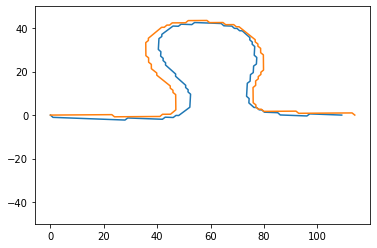

30083.086608705977

In [455]:
print(sidePieces[3].id," ",sidePieces[62].id )
plot_2_edges(sidePieces[3].edges[2],sidePieces[62].edges[2])

edge1, edge2 = sidePieces[0].edges[0],sidePieces[102].edges[3]
compare_edges(edge1,edge2)

In [445]:
test()

[(1243.1925704776368, 62, 2), (1429.2379204859255, 66, 2), (1746.3676515823354, 35, 2), (1774.5554911623472, 10, 1), (1902.568064009027, 6, 0), (1955.9907518604334, 37, 0), (2290.5248597150376, 84, 2), (2443.6087785816517, 97, 2), (2488.8176926368033, 77, 2), (2596.134594757165, 24, 3), (2602.203623225659, 65, 0), (2780.169725876314, 16, 0), (3012.0504244055423, 83, 0), (3102.722639203102, 42, 1), (3201.6524538720946, 72, 2), (3372.464979550423, 61, 2), (3475.329270010722, 25, 1), (3565.3516064319588, 82, 2), (3583.91824266139, 26, 2), (3596.3466859182113, 86, 2)]


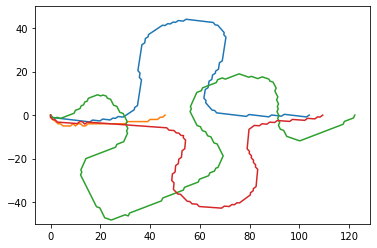

In [454]:
plot_normed_edges(sidePieces[18:19])